# Quantics QTT factorization of a 2-dimensional function

This tutorial shows the QTT quantics approach for a 2-dimensional function.
The function is an artificial example but choosen such to have features at very different lengthscales.
The concrete form is

$$
f(x,y) = e^{-0.4 (x^2 + y^2)} + 1 + \sin(x y) e^{-x^2} + \cos(3 x y ) e^{ -y^2} + \cos(x + y)
+ 5 \times 10^{-2} \cos(200 (x - 2 y)) + 5 \times 10^{-4} \cos(1000 (2 x - 7 y)) + 10^{-5} \cos(2 \times 10^{8} x)).
$$

First, the *xfacpy* module is imported together with standard Python modules for mathematics and plotting.

In [1]:
import xfacpy

import numpy as np
from math import cos, sin, exp
import matplotlib.pyplot as plt
import pylab

The function $f(x, y)$ is defined in the next cell. For n-dimensional functions, *xfacpy* expects a vector-valued argument of the function.
The type of the function argument ``arg`` will be a list of real values, which is easily unpacked in line ``x, y = arg``.

In [11]:
def f(arg):
    x, y = arg
    res = (exp(-0.4 * (x**2 + y**2)) + 1 + sin(x * y) * exp(-x**2)
            + cos(3 * x * y) * exp(-y**2) + cos(x + y) + 0.05 * cos(200 * (x - 2 * y))
            + 0.0005 * cos(1000 * (2 * x - 7 * y)) 
            + 1e-5 * cos(2e8 * x))
    return res

We will work with a 2-dimensional quantics where each dimension $x, y$ is discretized on $2^R$ points on an interval [a,b), such that
$x_i=a+i\Delta$, where $\Delta = (b -a)/2^R $ and $i=0,1,...,2^R-1 $. The discretization for $y_i$ is identical.

In the next code block, we set up a 2-dimensional quantics grid with maximal range $x, y \in [-5, 5)$ and a resolution of $R=40$ bits.

In [ ]:
qgrid = xfacpy.QuanticsGrid(a=-5, b=5, dim=2, nBit=40)

The next line 1 and 2 modify the default parameters to set the maximal bond dimension to 100.
The quantics tensor is then instatinated in line 4 and the object `ci` is both a `QTensorCI` and a `TensorCI2`. 
The iteration in line 6 and 7 performs the actual factorization.
Line 9 gets the tensor train approximation, which represents the QTT approximated function $\tilde{f}$.

In [18]:
args = xfacpy.TensorCI2Param()  # set max bond dimension
args.bondDim = 100

ci = xfacpy.QTensorCI(f=f, qgrid=qgrid, args=args)  # construct a tci of the quantics tensor

while not ci.isDone():
    ci.iterate()

qtt=ci.get_qtt()  # the actual function approximating f

The factorization can be checked by plotting the relative in-sample error versus the number of half-sweeps (iterations).

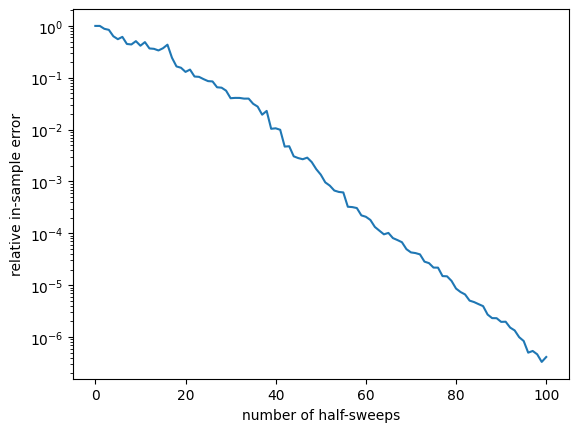

In [20]:
plt.plot(np.array(ci.pivotError) / ci.pivotError[0], linestyle='solid')
plt.yscale('log')
plt.xlabel('number of half-sweeps')
plt.ylabel('relative in-sample error')
plt.show()

To show that the features of the function have been correctly leared, we plot the quantics approximation $\tilde{f}$ (left column) and the error to the exact function $|\tilde{f} - f|$ (right column) at various scales in the 2-dimensional plane (upper to lower panels).

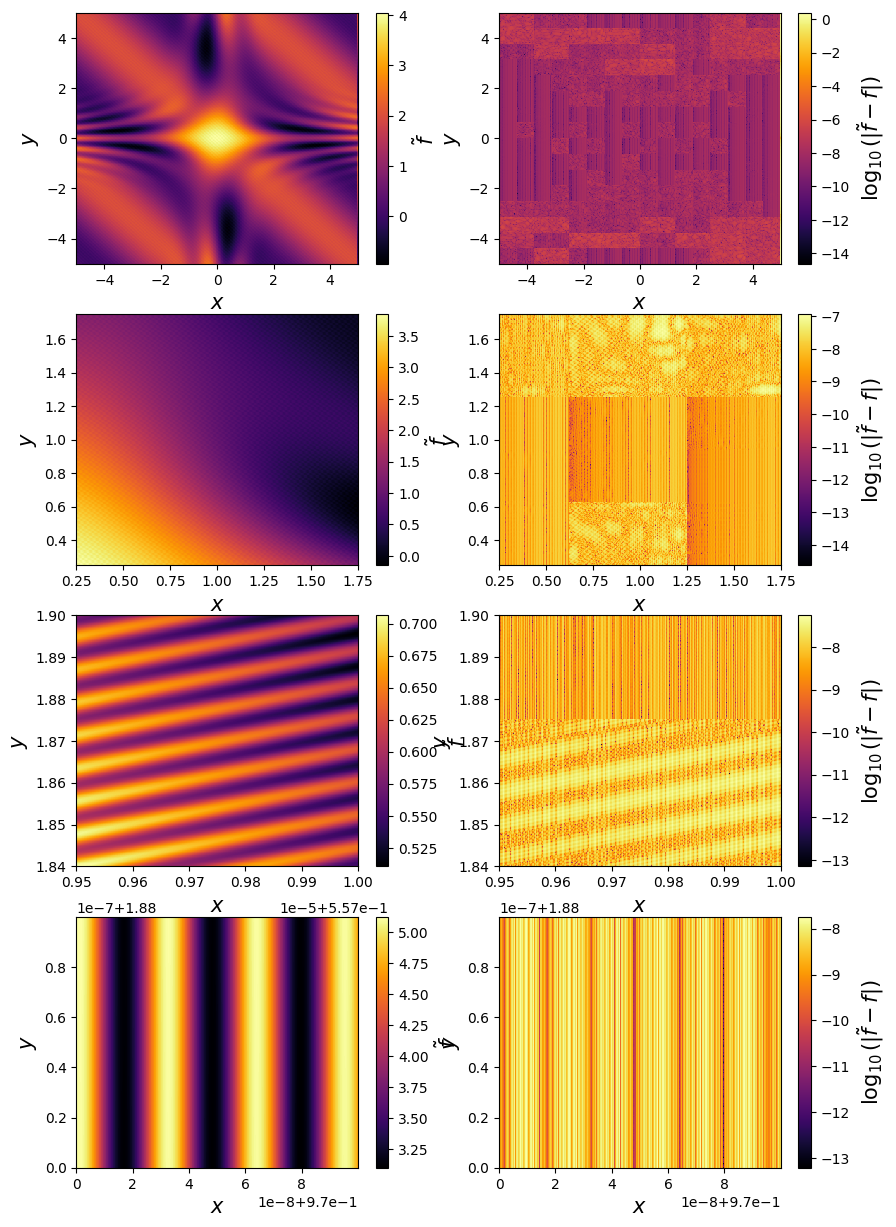

In [21]:
ranges = [(-5, 5, -5, 5), (0.25, 1.75, 0.25, 1.75), (0.95, 1.0, 1.84, 1.9), (0.97, 0.97+1e-7, 1.88, 1.88+1e-7)]
fig, axs = plt.subplots(len(ranges), 2)
fig.set_size_inches(10, 15)

for i, (xmin, xmax, ymin, ymax) in enumerate(ranges):

    xval = np.linspace(xmin, xmax, 400)
    yval = np.linspace(ymin, ymax, 400)
    
    fdat = np.array([[qtt.eval([x, y]) for y in yval] for x in xval])
    extent=[min(xval), max(xval), min(yval), max(yval)]
    pcm = axs[i, 0].imshow(fdat.T, interpolation='none', origin='lower', extent=extent, aspect='auto', cmap="inferno")
    cb = fig.colorbar(pcm, ax=axs[i, 0])
    cb.set_label(r'$\tilde{f}$', fontsize = 15)
    
    fdat_ref = np.array([[f([x, y]) for y in yval] for x in xval])
    pcm = axs[i, 1].imshow(np.log10(np.abs(fdat.T - fdat_ref.T)), interpolation='none', origin='lower', extent=extent, aspect='auto', cmap="inferno")
    cb = fig.colorbar(pcm, ax=axs[i, 1])
    cb.set_label(r'$\log_{10}(|\tilde{f} - f|)$', fontsize = 15)

    for j in [0, 1]:
        axs[i, j].set_xlabel(r'$x$', fontsize=15)
        axs[i, j].set_ylabel(r'$y$', fontsize=15)
        axs[i, j].set_xlim(xmin, xmax)
        axs[i, j].set_ylim(ymin, ymax)

plt.show()

Above plots show that the quantics factorization accurately learned all oscillation patterns which are dominant at a certain scale.